In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.core.frame import DataFrame
from scipy import stats

In [2]:
data = pd.read_csv('data\\data.csv', sep=';')
data.head()

,Z1-4,Z5A,Z5B,Z6I,Z6IIA,Z6IIB,Z7A,Z7B,Z8A,Z8B,Z9A,Z9B,Z10A,Z10B,Z11,Z12,Z13,"Z14,15,16_x","Z14,15,16_y",Unnamed: 19
0,122.3,152.0,158.8,B,133.7,131.6,168.3,172.2,54.9,76.3,85.8,154.7,24.7,27.7,103.3,100.7,118.5,120.6,84.4,NaN
1,117.9,161.4,159.2,B,170.7,157.0,173.2,154.7,50.9,60.9,134.8,137.2,18.4,20.4,93.9,91.5,122.4,124.2,76.9,NaN
2,118.0,140.1,151.5,B,169.2,155.3,186.1,167.4,28.2,66.2,174.0,146.7,29.5,30.4,96.3,96.5,120.4,126.2,82.3,NaN
3,124.0,147.0,160.4,B,163.1,148.2,160.7,176.6,54.2,89.9,177.9,142.9,30.2,25.8,92.2,94.3,117.9,127.6,80.0,NaN
4,126.5,150.6,152.2,B,144.1,143.4,177.9,160.7,42.7,68.9,163.4,136.3,20.7,26.0,97.4,104.7,120.3,128.9,76.7,NaN


# Проверка гипотез однородности

## Одновыборочный критерий Стьюдента

Имеется одна выборка из нормального распределения. Требуется проверить гипотезу о том, что среднее значение этого распределения не превосходит заданной величины Nu.

In [3]:
def single_student_criterion(data: np.array,
                             nu: float=0,
                             alp: float=0.1, 
                             alternative: str='more'):
    """
    Одновыборочный критерий Стьюдента
    Args:
        data: данные, где указаны успехи - 1, неудачи - 0
        nu: константа для гипотезы H0 = nu
        alp: уровень значимости
        alternative (more, less, difference): X > nu - more,
                                                X < nu - less,
                                                X != nu - difference
    """
    n = data.shape[0]
    data_mean = data.mean()
    data_std = data.std()
    
    T_stat = (data_mean - nu) * math.sqrt(n) / data_std
    
    if alternative == 'more':
        p_value = 1 - stats.t.cdf(T_stat, df=n - 1)
        c_crit = stats.t.ppf(1 - alp, df=n - 1)
    elif alternative == 'less':
        p_value = stats.t.cdf(T_stat, df=n - 1)
        c_crit = stats.t.ppf(alp, df=n - 1)
    elif alternative == 'difference':
        p_value = 2 * (1 - stats.t.cdf(abs(T_stat), df=n - 1))
        c_crit = stats.t.ppf(1 - alp / 2, df=n - 1)
    else:
        raise Exception('Alternative should be like more, less, difference!')
    
    print("Т cтатистика:", T_stat)
    print("Уровень значимость:", alp)
    
    if alternative == 'more':
        print("Крит. область T >", c_crit)
    elif alternative == 'less':
        print("Крит. область T <", c_crit)
    elif alternative == 'difference':
        print("Крит. область |T| >", c_crit)
    else:
        raise Exception('Alternative should be like more, less, difference!')
    print('p-value:', p_value)
    if p_value < alp:
        print(f"Гипотеза отклоняется, приниматеся альтернатива {alternative}!")
    else:
        print(f"Гипотеза не отклоняется Nu = {nu}")

In [11]:
X_data = data['Z5A'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z5B'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

single_student_criterion(Y_data - X_data, nu=0, alternative='more')

Т cтатистика: 15.0866176529239
Уровень значимость: 0.1
Крит. область T > 1.2934205074564602
p-value: 0.0
Гипотеза отклоняется, приниматеся альтернатива more!


## Критерий знаков

Одновыборочный:
Имеется выборка X(n) из с.в. X = I(A), где A — некоторое событие. Требуется проверить гипотезу, что событие A происходит чаще, чем противоположное к этому событию утверждение (например, лечение чаще приводит к выздоровлению).

Двухвыборочный:
Имеются две выборки X(n), Y(n) одинакового объема. Известно, что каждая пара i-х наблюдений Xi, Yi — наблюдения некоторых характеристик (с.в. X и Y ) у одного и того же i-го объекта. Распределение X и Y неизвестно. Требуется проверить гипотезу однородности выборок.

In [13]:
def signs_criterion(data: np.array,
                   p0: float=0.5,
                   alp: float=0.1,
                   alternative: str='more'):
    """
    Критерий знаков
    Args:
        data: данные
        p0: гипотеза значение вероятности успеха
        alp: уровень значимости
        alternative (more, less): p > p0 - more,
                                    p < p0 - less
    """
    M = sum(data)
    n = data.shape[0]
    
    print('Статистика:', M)
    print('Уровень значимости:', alp)
    
    C_crit = 0
    if alternative == 'more':
        min_pmf = 1
        for c in range(n + 1):
            pmf_bin = stats.binom.pmf(c, n=n, p=p0)
            if pmf_bin >= 1 - alp and min_pmf > pmf_bin:
                C_crit = c - 1
                min_pmf = pmf_bin
        
        p_value = 1 - stats.binom.pmf(M, n=n, p=p0)
        print(f'Крит. область M > {C_crit}')
    elif alternative == 'less':
        max_pmf = 0
        for c in range(n + 1):
            pmf_bin = stats.binom.pmf(c, n=n, p=p0)
            if pmf_bin <= alp and max_pmf < pmf_bin:
                C_crit = c
                max_pmf = pmf_bin
        
        p_value = stats.binom.pmf(M + 1, n=n, p=p0)
        print(f'Крит. область M < {C_crit}')
    else:
        raise Exception('Alternative should be like more or less!')
    print('p-value:', p_value)
    
    if p_value < alp:
        print(f'Гипотеза отклоняется, принимается альтернатива {alternative}!')
    else:
        print(f'Гипотеза не отклоняется, p = {p0}!')

In [16]:
X_data = data['Z6IIA'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z6IIB'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

signs_criterion(Y_data < X_data, p0=0.5, alternative='less')

Статистика: 33
Уровень значимости: 0.1
Крит. область M < 20
p-value: 5.820766091346741e-11
Гипотеза отклоняется, принимается альтернатива less!


## Двухвыборочный критерий Стьюдента

Имеются две выборки X(n1), Y(n2), относящиеся к двум независимым группам наблюдений одной и той же характеристики, подчиняющейся нормальному закону с одинаковыми для обеих выборок дисперсиями.
Требуется проверить гипотезу однородности выборок.

In [17]:
def two_student_criterion(x_data: np.array,
                          y_data: np.array,
                          alp: float=0.1,
                          alternative: str='more'):
    """
    Двухвыборочный критерий Стьюдента
    Args:
        x_data: Данные X
        y_data: Данные Y
        alp: уровень значимости
        alternative (more, less, difference): nu1 > nu2 - more,
                                                nu1 < nu2 - less,
                                                nu1 != nu2 - difference
    """
    n1 = x_data.shape[0]
    n2 = y_data.shape[0]
    x_mean = np.mean(x_data)
    y_mean = np.mean(y_data)
    x_var = np.var(x_data, ddof=0)
    y_var = np.var(y_data, ddof=0)

    T_stat = (x_mean - y_mean) * math.sqrt(n1 * n2 * (n1 + n2 - 2))\
            / math.sqrt((n1 * x_var + n2 * y_var) * (n1 + n2))
    
    if alternative == 'more':
        p_value = 1 - stats.t.cdf(T_stat, df=n1 + n2 - 1)
        c_crit = stats.t.ppf(1 - alp, df=n1 + n2 - 1)
    elif alternative == 'less':
        p_value = stats.t.cdf(T_stat, df=n1 + n2 - 1)
        c_crit = stats.t.ppf(alp, df=n1 + n2 - 1)
    elif alternative == 'difference':
        p_value = 2 * (1 - stats.t.cdf(abs(T_stat), df=n1 + n2 - 1))
        c_crit = stats.t.ppf(1 - alp / 2, df=n1 + n2 - 1)
    else:
        raise Exception('Alternative should be like more, less, difference!')
    
    print("Т cтатистика:", T_stat)
    print("Уровень значимость:", alp)
    
    if alternative == 'more':
        print("Крит. область T >", c_crit)
    elif alternative == 'less':
        print("Крит. область T <", c_crit)
    elif alternative == 'difference':
        print("Крит. область |T| >", c_crit)
    else:
        raise Exception('Alternative should be like more, less, difference!')
    
    print('p-value:', p_value)
    if p_value < alp:
        print(f"Гипотеза отклоняется, приниматеся альтернатива {alternative}!")
    else:
        print(f"Гипотеза не отклоняется Nu = {nu}")

In [18]:
X_data = data['Z7A'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z7B'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

two_student_criterion(X_data, Y_data, alternative='difference')

Т cтатистика: 1.8589914988939584
Уровень значимость: 0.1
Крит. область |T| > 1.669013024840352
p-value: 0.06762703937242898
Гипотеза отклоняется, приниматеся альтернатива difference!


##  Критерий Вилкоксона

Имеются две выборки X(n1), Y(n2), относящиеся к двум независимым группам наблюдений одной и той же характеристики. Требуется проверить гипотезу однородности выборок в ситуации, когда в качестве альтернативы ожидается, что значения в 1-й выборке будут «равномерно» меньше значений во второй выборке.


In [44]:
def wilcoxon_crit(x_data: np.array,
                  y_data: np.array,
                  alp: float=0.1):
    """
    Критерий Вилкоксона
    Args:
        x_data: Данные X
        y_data: Данные Y
        alp: уровень значимости
    """
    n1 = x_data.shape[0]
    n2 = y_data.shape[0]
    x_data.sort()
    y_data.sort()
    
    full_data = np.hstack((x_data, y_data))
    argsort_full_data = np.argsort(full_data)
    
    count_eq = np.array([sum(full_data == x1) for x1 in x_data])
    rangs = np.arange(1, n1 + n2 + 1)
    x_rangs = rangs[argsort_full_data < n1]
    x_rangs = x_rangs + (count_eq - 1) / 2
    
    W_stat = sum(x_rangs)
    W_mean = 0.5 + n1 * (n1 + n2 + 1) / 2
    W_var = n1 * n2 * (n1 + n2 + 1) / 12
    
    p_value = 1 - stats.norm.cdf(W_stat, W_mean, math.sqrt(W_var))
    #C_crit = stats.norm.ppf(alp, W_mean, math.sqrt(W_var))
    
    print("Т cтатистика:", W_stat)
    print("Уровень значимость:", alp)
    #print(f"Крит. область W < {C_crit}")
    print("p-value:", p_value)
    if p_value < alp:
        print(f"Гипотеза отклоняется, приниматеся альтернатива Fy < Fx!")
    else:
        print(f"Гипотеза не отклоняется Fy = Fx")

In [45]:
X_data = data['Z8A'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z8B'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

wilcoxon_crit(X_data, Y_data)

Т cтатистика: 490.0
Уровень значимость: 0.1
p-value: 0.9999999960158171
Гипотеза не отклоняется Fy = Fx


## Критерий Фишера. Критерий сравнения дисперсий

Имеются две выборки X(n1), Y(n2), относящиеся к двум независимым группам наблюдений одной и той же характеристики, подчиняющейся нормальному закону. Требуется сравнить дисперсии наблюдений в этих групп.

In [46]:
def fischer_crit(x_data: np.array,
                 y_data: np.array,
                 alp: float=0.1,
                 alternative: str='more'):
    """
    Критерий Вилкоксона
    Args:
        x_data: Данные X
        y_data: Данные Y
        alp: уровень значимости
        alternative (more, less, difference): Sx > Sy - more,
                                                Sx < Sy - less,
                                                Sx != Sy - difference
    """
    x_var = np.var(x_data, ddof=1)
    y_var = np.var(y_data, ddof=1)
    n1 = x_data.shape[0]
    n2 = y_data.shape[0]
    k = n1 - 1
    m = n2 - 1
    
    F_stat = x_var / y_var
    
    if alternative == 'more':
        p_value = 1 - stats.f.cdf(F_stat, dfn=k, dfd=m)
        c_crit = stats.f.ppf(1 - alp, dfn=k, dfd=m)
    elif alternative == 'less':
        p_value = stats.f.cdf(F_stat, dfn=k, dfd=m)
        c_crit = stats.f.ppf(alp, dfn=k, dfd=m)
    elif alternative == 'difference':
        p_value = 2 * (1 - stats.f.cdf(abs(F_stat), dfn=k, dfd=m))
        c_crit = stats.f.ppf(1 - alp / 2, dfn=k, dfd=m)
    else:
        raise Exception('Alternative should be like more, less, difference!')
    
    print("F cтатистика:", F_stat)
    print("Уровень значимость:", alp)
    
    if alternative == 'more':
        print("Крит. область T >", c_crit)
    elif alternative == 'less':
        print("Крит. область T <", c_crit)
    elif alternative == 'difference':
        print("Крит. область |T| >", c_crit)
    else:
        raise Exception('Alternative should be like more, less, difference!')
    
    print('p-value:', p_value)
    if p_value < alp:
        print(f"Гипотеза отклоняется, приниматеся альтернатива {alternative}!")
    else:
        print(f"Гипотеза не отклоняется Sx = Sy!")

In [47]:
X_data = data['Z9A'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z9B'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

fischer_crit(X_data, Y_data, alternative='less')

F cтатистика: 0.977977202965521
Уровень значимость: 0.1
Крит. область T < 0.7373002717196183
p-value: 0.4633821083663101
Гипотеза не отклоняется Sx = Sy!


##  Критерий однородности хи-квадрат

Имеются две выборки X(n1), Y(n2), относящиеся к двум независимым группам наблюдений одной и той же характеристики. Требуется проверить гипотезу однородности выборок в ситуации, когда неизвестна модель распределения выборок, и нет никакой информации о соотношении между этими выборками.

In [51]:
def chi2_uniformity_crit(x_data: np.array,
                         y_data: np.array,
                         start: float,
                         delta: float,
                         r: int,
                         alp: float=0.1):
    """
    Критерий однородности Хи-квадрат
    Args:
        x_data: Данные X
        y_data: Данные Y
        start: первая граница интервала
        delta: шаг между границами интервала
        r: количество интервалов
        alp: уровень значимости
    """
    n1 = x_data.shape[0]
    n2 = y_data.shape[0]
    
    interval = np.array([start + i * delta for i in range(r - 1)])
    
    f_xy = np.zeros((r, 2))
    for i in range(r):
        if i == 0:
            x_cond = x_data < interval[0]
            y_cond = y_data < interval[0]
        elif i == r - 1:
            x_cond = x_data >= interval[-1]
            y_cond = y_data >= interval[-1]
        else:
            x_cond = np.all((x_data >= interval[i-1],
                             x_data < interval[i]), axis=0)
            y_cond = np.all((y_data >= interval[i-1],
                             y_data < interval[i]), axis=0)
        
        f_xy[i][0] = sum(x_cond)
        f_xy[i][1] = sum(y_cond)
    
    f_xy = np.hstack((f_xy, f_xy.sum(axis=1).reshape(-1, 1))) # freq_i*
    f_xy = np.vstack((f_xy, f_xy.sum(axis=0).reshape(1, -1))) # freq_*2
    
    T_stat = n1 * n2 * sum([((f_xy[i][0] / n1 - f_xy[i][1] / n2) ** 2) / f_xy[i][-1]\
             for i in range(r) if f_xy[i][-1] != 0])
    
    print("Хи^2 cтатистика:", T_stat)
    print("Уровень значимость:", alp)
    
    p_value = 1 - stats.chi2.cdf(T_stat, df=r - 1)
    T_crit = stats.chi2.ppf(alp, df=r - 1)
    print(f"Крит. область T < {T_crit}")
    
    print('p-value:', p_value)
    if p_value < alp:
        print(f"Гипотеза отклоняется, выборки не однородные!")
    else:
        print(f"Гипотеза не отклоняется, выборки однородные!")

In [52]:
X_data = data['Z10A'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z10B'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

chi2_uniformity_crit(X_data, Y_data,
                     start=19.3, delta=1.5, r=10)

Хи^2 cтатистика: 5.874181218648049
Уровень значимость: 0.1
Крит. область T < 4.168159008146107
p-value: 0.7524417747210342
Гипотеза не отклоняется, выборки однородные!


## Критерий однородности Смиронова

Пусть X(n) ∼ F и Y(m) ∼ G — две независимые выборки. Требуется проверить гипотезу H0 : F = G о совпадении функции распределения выборки X(n) с функцией распределения выборки Y(m).

In [53]:
def kolmogorov_uniformity_crit(x_data: np.array,
                               y_data: np.array,
                               alp: float=0.1):
    """
    Критерий однородности Колмогорова
    Args:
        x_data: Данные X
        y_data: Данные Y
        alp: уровень значимости
    """
    x_data.sort()
    y_data.sort()
    
    xy_data = np.unique(np.hstack((x_data, y_data)))
    xy_data.sort()
    
    n = x_data.shape[0]
    m = y_data.shape[0]
    xy_n = xy_data.shape[0]
    
    x_X_edf, y_X_edf = [xy_data[0]], [0]
    for i in range(1, xy_n):
        f_n = sum(x_data < xy_data[i]) / n
        x_X_edf.append(xy_data[i - 1])
        y_X_edf.append(f_n)
        
        x_X_edf.append(xy_data[i])
        y_X_edf.append(f_n)
    x_X_edf.append(xy_data[-1])
    y_X_edf.append(1)
    
    x_Y_edf, y_Y_edf = [xy_data[0]], [0]
    for i in range(1, xy_n):
        f_n = sum(y_data < xy_data[i]) / m
        x_Y_edf.append(xy_data[i - 1])
        y_Y_edf.append(f_n)
        
        x_Y_edf.append(xy_data[i])
        y_Y_edf.append(f_n)
    x_Y_edf.append(xy_data[-1])
    y_Y_edf.append(1)
    
    D = abs(np.array(y_X_edf) - np.array(y_Y_edf))
    arg_delta = np.argmax(D)
    D = D[arg_delta]
    
    arg_D = x_X_edf[arg_delta]
    val_D = y_X_edf[arg_delta]
    
    direct = 1
    if y_Y_edf[arg_delta] < y_X_edf[arg_delta]:
        direct = -1
    x_D = [arg_D, arg_D]
    y_D = [val_D, val_D + direct * D]

    fig, axs = plt.subplots(1, 1, figsize=(7, 7))
    axs.set_title('Критерий однородности Колмогорова')
    axs.plot(x_X_edf, y_X_edf, label='ЭФР данных X')
    axs.plot(x_Y_edf, y_Y_edf, label='ЭФР данных Y')
    axs.plot(x_D, y_D, 'r', label=f'D_nm = {D}')
    axs.set_xlabel('x')
    axs.set_ylabel('F(x)')
    axs.legend()
    plt.show()
    
    kolm_stat = math.sqrt(n * m / (n + m)) * D
    p_value = 2 * (math.e ** (-2 * kolm_stat * kolm_stat))
    c_crit = math.sqrt(-0.5 * math.log(alp / 2))
    
    print("D_nm:", kolm_stat)
    print("Уровень значимость:", alp)
    print(f"Крит. область Dn > {c_crit}")
    print("p-value:", p_value)
    if kolm_stat > c_crit:
        print(f"Гипотеза отклоняется, выборки не однородные!")
    else:
        print(f"Гипотеза не отклоняется, выборки однородные!")

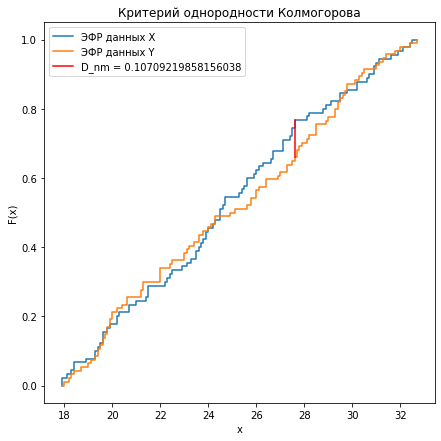

D_nm: 0.7261629799504445
Уровень значимость: 0.1
Крит. область Dn > 1.2238734153404083
p-value: 0.6966458062363737
Гипотеза не отклоняется, выборки однородные!


In [54]:
X_data = data['Z10A'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z10B'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

kolmogorov_uniformity_crit(X_data, Y_data)